# Airfoil shape optimization via Reinforcement Learning

In this example we will show the steps to train an agent that optimizes airfoils. We will reproduce some of the results of [https://arxiv.org/abs/2505.02634](https://arxiv.org/abs/2505.02634)   

First, we will start by importing the necessary functions and classes and defining the operating conditions

## Define operating conditions

In [1]:
%load_ext autoreload
%autoreload 2

from pyLOM.RL import (
    create_env,
    AirfoilOperatingConditions,
    AirfoilCSTParametrizer,
    AirfoilParameterizerConfig,
    NeuralFoilSolver,
)
from stable_baselines3 import PPO
import gymnasium as gym


0 Warning! Import - NVTX not present!


In [2]:
operating_conditions = AirfoilOperatingConditions(
    alpha=4.0,
    mach=0.2,
    Reynolds=1e6,
)

## Shape parameterization and design space

Now we need to define the design space where the agent is going to be trained on. We use a CST parameterization, so the bounds for the upper and lower surfaces, leading-edge weight and trailing-edge thickness need to be defined. We can instantiate directly an `AirfoilCSTParametrizer`

In [3]:
leading_edge_weight_min, leading_edge_weight_max = -0.05, 0.75
TE_thickness_min, TE_thickness_max = 0.0005, 0.01
upper_edge_min, upper_edge_max = -1.5, 1.25
lower_edge_min, lower_edge_max = -0.75, 1.5
n_weights_per_side = 8

parameterizer = AirfoilCSTParametrizer(
    upper_surface_bounds=(
        [upper_edge_min] * n_weights_per_side,
        [upper_edge_max] * n_weights_per_side,
    ),
    lower_surface_bounds=(
        [lower_edge_min] * n_weights_per_side,
        [lower_edge_max] * n_weights_per_side,
    ),
    TE_thickness_bounds=(
        TE_thickness_min,
        TE_thickness_max,
    ),
    leading_edge_weight=(
        leading_edge_weight_min,
        leading_edge_weight_max,
    ),
)

As it can be seen, the airfoils will be defined by 18 parameters. We can use an `AirfoilParameterizerConfig` to create a parameterizer instead

In [4]:
parameterizer = AirfoilParameterizerConfig().create_parameterizer()

If no parameters are passed, it will create a parameterizer with default params, which are exactly the same as the ones defined on the previous cell.

## Define the solver

Now we need to create a solver that will give us the lift-to-drag ratio of a given airfoil, for this example, we will use NeuralFoil as it quite faster than XFoil. Here, we need to specify the operating conditions, that have been defined before.

In [5]:
solver = NeuralFoilSolver(
    alpha=operating_conditions.alpha,
    Reynolds=operating_conditions.Reynolds,
)

## Create the environment

Now we have everything we need to create an environment. We will set the maximum length of an episode to 64.

Note: if you have been following the [paper](https://arxiv.org/abs/2505.02634), there is a term $\sigma$ that penalizes changes on the maximum thickness. If this term wants to be added to the environment, you can use the parameter `thickness_penalization_factor` when creating the environment. For the example, we will leave that to 0, its defaul value.

In [6]:
env = gym.make(
    "ShapeOptimizationEnv-v0",
    solver=solver,
    parameterizer=parameterizer,
    episode_max_length=64,
)

/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/david/miniconda/envs/pylom-rl/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Great, now we've leared to create an enviroment, but you can do all of this in just one line, using the built-in function on pyLOM, `create_env`. This function takes different parameters that gives the option to customize the environment. Additionally, with this funcion you can create parallel environment to speed up the training usign the parameter `num_envs`.

The only required parameter is the `solver_name`, the rest od them have a default value.

In [7]:
env = create_env("neuralfoil", operating_conditions=operating_conditions)

You can see the internal state of the environment calling the `render` method

(None, Airfoil Untitled (Kulfan / CST parameterization))

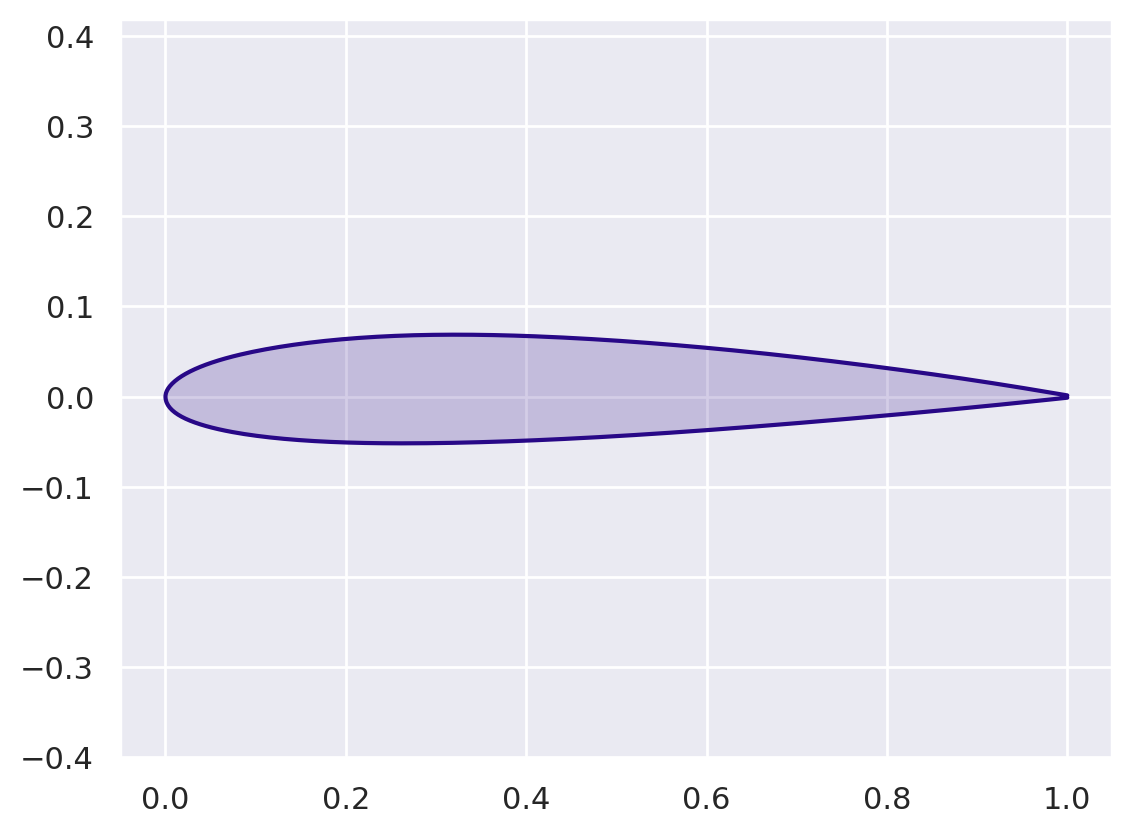

In [17]:
env.reset()
env.render()

## Define the PPO agent and train it on the environment

We define the same hyperparameters used to train an agent with neuralfoil on the previously mentioned paper. An important note here is hta if you want to use parallel environment you should divide the value of the parameter `n_steps` by the number of environments used.

In [ ]:
ppo_parameters = {
    "learning_rate": 2.5e-4,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.3,
    "ent_coef": 0, 
    "clip_range": 0.6,
    "verbose": 1,
    "device": "cpu",
    "policy_kwargs": {"net_arch": dict(pi=[256, 256], vf=[256, 256])},
}

training_timesteps = 25000

model = PPO("MlpPolicy", env, **ppo_parameters)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=training_timesteps)
model.save("airfoil_agent")

If you want to use a model that is already trained you can load it

In [8]:
model = PPO.load("airfoil_agent")

## Evaluate the agent

Now we can evaluate and play with the agent. pyLOM has its own methods to make the evaluations and to plot the optimization process of an airfoil

In [ ]:
from pyLOM.RL import (
    evaluate_airfoil_agent,
    run_episode,
    create_airfoil_optimization_progress_plot,
)
import aerosandbox as asb

In [ ]:
airfoil_to_optimize = "naca0012"
airfoil = asb.Airfoil(airfoil_to_optimize)
rewards, states = run_episode(model, env, reset_options={"initial_shape": airfoil})


Now we can create a plot showing the optimization process using the function `create_airfoil_optimization_progress_plot`. However, that function expects as its first parameter a list of `asb.Airfoil` and the function `run_episode` returns `states` which is a list of vectors from the design space, so we need to create the airfoils. Fortunately, the parameterizer we created before can do exactly that, the next cell converts the vectors to actual Airfoils

In [25]:
airfoils = list(map(lambda x: parameterizer.get_shape_from_params(x), states))

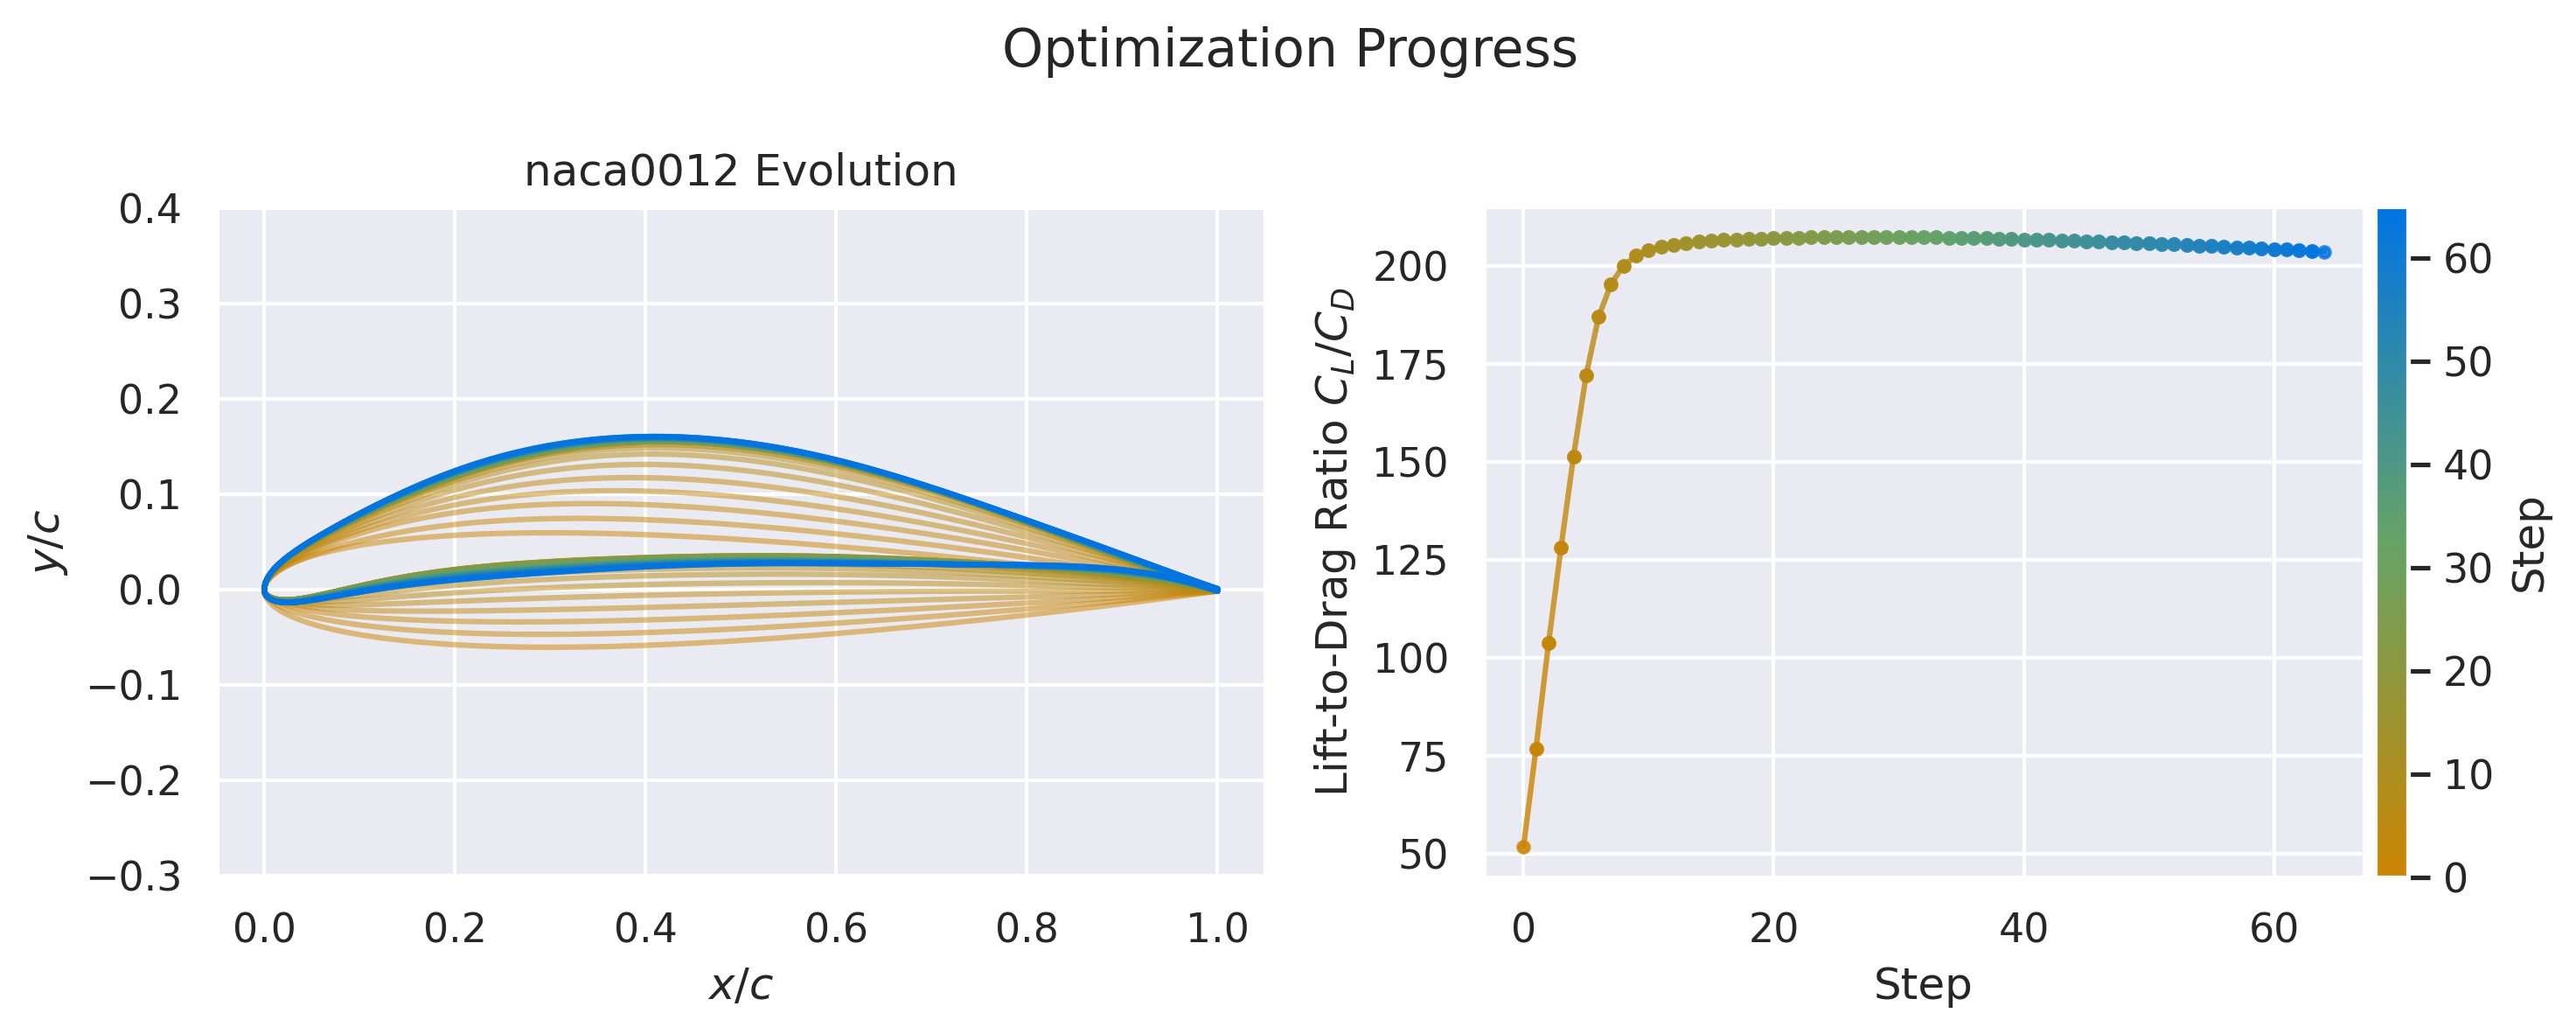

In [ ]:
create_airfoil_optimization_progress_plot(
    airfoils, rewards, airfoil_name=airfoil_to_optimize
)
